# Setup Pre-reqs

In [9]:
%%configure -f
{
  "conf": {
    "spark.sql.extensions":  "io.delta.sql.DeltaSparkSessionExtension",
    "spark.sql.catalog.spark_catalog":  "org.apache.spark.sql.delta.catalog.DeltaCatalog",
    "spark.jars":"hdfs:///apps/hudi/lib/hudi-spark-bundle.jar",
    "spark.serializer":"org.apache.spark.serializer.KryoSerializer",
    "spark.sql.catalog.spark_catalog": "org.apache.spark.sql.hudi.catalog.HoodieCatalog",
    "spark.sql.extensions":"org.apache.spark.sql.hudi.HoodieSparkSessionExtension",
    "spark.sql.iceberg.vectorization.enabled":"false"
  }
}

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


In [6]:
%%configure  -f
{ "conf": {
            "spark.jars":"hdfs:///apps/hudi/lib/hudi-spark-bundle.jar",
            "spark.serializer":"org.apache.spark.serializer.KryoSerializer",
            "spark.sql.catalog.spark_catalog": "org.apache.spark.sql.hudi.catalog.HoodieCatalog",
            "spark.sql.extensions":"org.apache.spark.sql.hudi.HoodieSparkSessionExtension",
            "spark.sql.iceberg.vectorization.enabled":"false"
          }}

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


In [10]:
import org.apache.spark.sql.SaveMode
import org.apache.spark.sql.functions._
import org.apache.hudi.DataSourceWriteOptions
import org.apache.hudi.DataSourceReadOptions
import org.apache.hudi.config.HoodieWriteConfig
import org.apache.hudi.hive.MultiPartKeysValueExtractor
import org.apache.hudi.hive.HiveSyncConfig
import org.apache.hudi.sync.common.HoodieSyncConfig

val hudiOptions = Map[String,String](
  HoodieWriteConfig.TBL_NAME.key -> "my_XTable",
  DataSourceWriteOptions.TABLE_TYPE.key -> "COPY_ON_WRITE"
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import org.apache.spark.sql.SaveMode
import org.apache.spark.sql.functions._
import org.apache.hudi.DataSourceWriteOptions
import org.apache.hudi.DataSourceReadOptions
import org.apache.hudi.config.HoodieWriteConfig
import org.apache.hudi.hive.MultiPartKeysValueExtractor
import org.apache.hudi.hive.HiveSyncConfig
import org.apache.hudi.sync.common.HoodieSyncConfig
hudiOptions: scala.collection.immutable.Map[String,String] = Map(hoodie.table.name -> my_XTable, hoodie.datasource.write.table.type -> COPY_ON_WRITE)


# Read Simple Parquet File

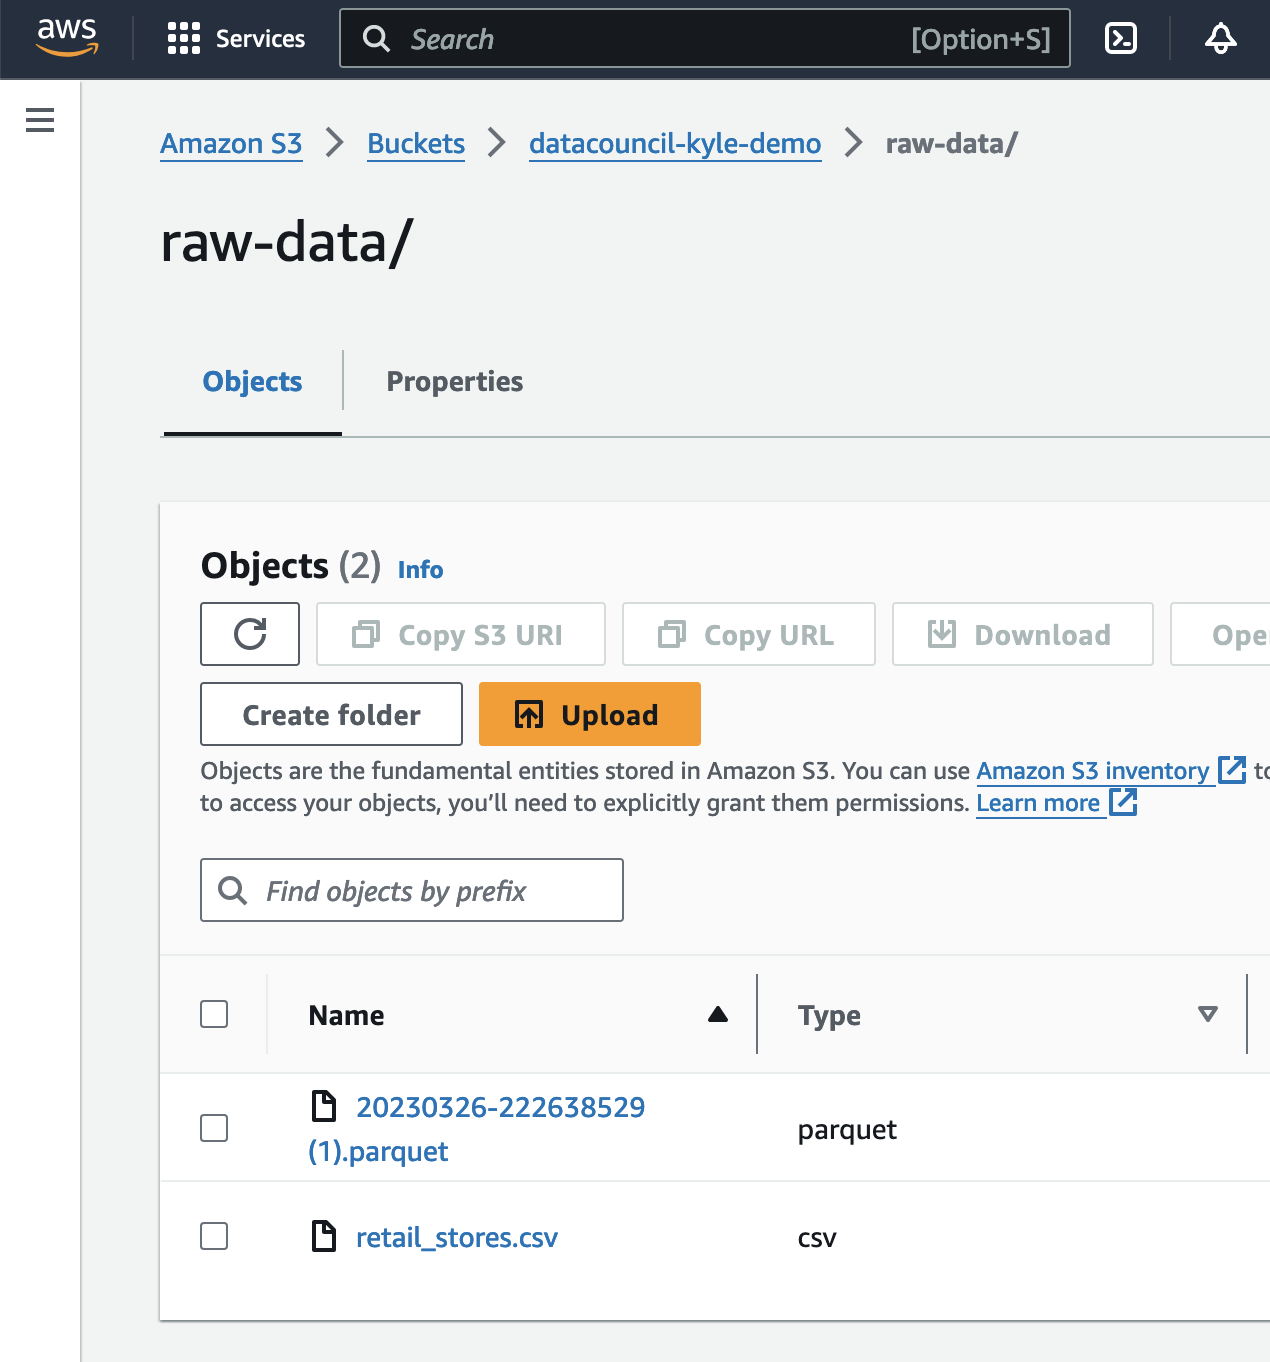

In [11]:
val df = spark.read.format("parquet").load("s3://path/to/myfile.parquet");

df.show();

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

df: org.apache.spark.sql.DataFrame = [Op: string, replicadmstimestamp: string ... 9 more fields]
+---+--------------------+---------+------+---------+---------+--------+-------------------+----------------+------------+----------------+
| Op| replicadmstimestamp|invoiceid|itemid| category|    price|quantity|          orderdate|destinationstate|shippingtype|        referral|
+---+--------------------+---------+------+---------+---------+--------+-------------------+----------------+------------+----------------+
|  I|2023-03-26 22:25:...|      190|    10|   Office|21.000000|       3|2016-04-28 00:00:00|              CA|       2-Day|           Other|
|  I|2023-03-26 22:25:...|     2450|    37|Household|24.000000|       4|2016-08-20 00:00:00|              KS|       2-Day|       Online Ad|
|  I|2023-03-26 22:25:...|     1164|    19|   Office|11.000000|       2|2016-02-06 00:00:00|              SC|       2-Day|       Online Ad|
|  I|2023-03-26 22:25:...|    16718|    18|   Garden|92.000000|

# First Write to Apache Hudi
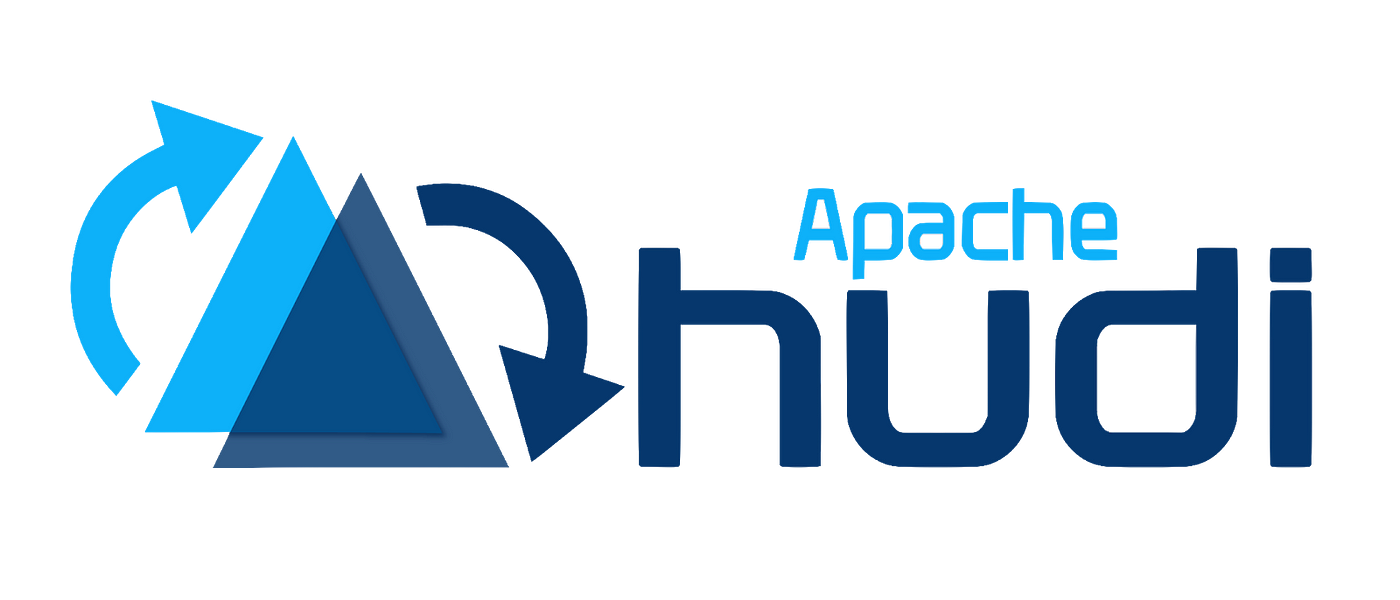

In [14]:
(df.write
  .format("hudi")
  .options(hudiOptions)
  .option("hoodie.metadata.enable", "false")
  .mode(SaveMode.Overwrite)
  .save("s3://path/to/my_XTable/"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## (Check S3 metadata)

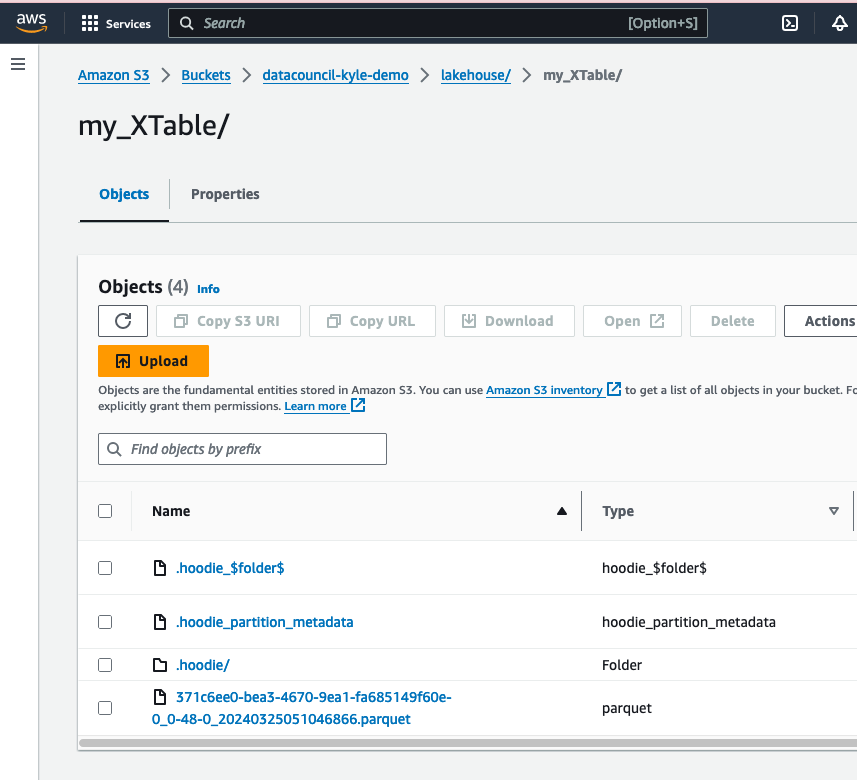

# Now Read as Hudi

In [15]:
spark.read.format("hudi").load("s3://path/to/my_XTable/").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------------------+--------------------+----------------------+--------------------+---+--------------------+---------+------+---------+---------+--------+-------------------+----------------+------------+----------------+
|_hoodie_commit_time|_hoodie_commit_seqno|  _hoodie_record_key|_hoodie_partition_path|   _hoodie_file_name| Op| replicadmstimestamp|invoiceid|itemid| category|    price|quantity|          orderdate|destinationstate|shippingtype|        referral|
+-------------------+--------------------+--------------------+----------------------+--------------------+---+--------------------+---------+------+---------+---------+--------+-------------------+----------------+------------+----------------+
|  20240325083336981|20240325083336981...|20240325083336981...|                      |a04d8a4f-ba15-4ad...|  I|2023-03-26 22:25:...|      190|    10|   Office|21.000000|       3|2016-04-28 00:00:00|              CA|       2-Day|           Other|
|  2024032508333

# Attempt read with Apache Iceberg

In [16]:
spark.read.format("iceberg").load("s3://path/to/my_XTable/").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
org.apache.spark.sql.catalyst.analysis.NoSuchTableException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `s3://datacouncil-kyle-demo/lakehouse/my_XTable`.`` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS.
  at org.apache.iceberg.spark.SparkCatalog.loadTable(SparkCatalog.java:161)
  at org.apache.spark.sql.connector.catalog.CatalogV2Util$.getTable(CatalogV2Util.scala:355)
  at org.apache.spark.sql.execution.datasources.v2.DataSourceV2Utils$.loadV2Source(DataSourceV2Utils.scala:137)
  at org.apache.spark.sql.DataFrameReader.$anonfun$load$1(DataFrameReader.scala:210)
  at scala.Option.flatMap(Option.scala:271)
  at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:208)
  at org.apache.spark.sql.DataFram

# SETUP XTABLE 
Follow documentation at: https://xtable.apache.org/docs/how-to

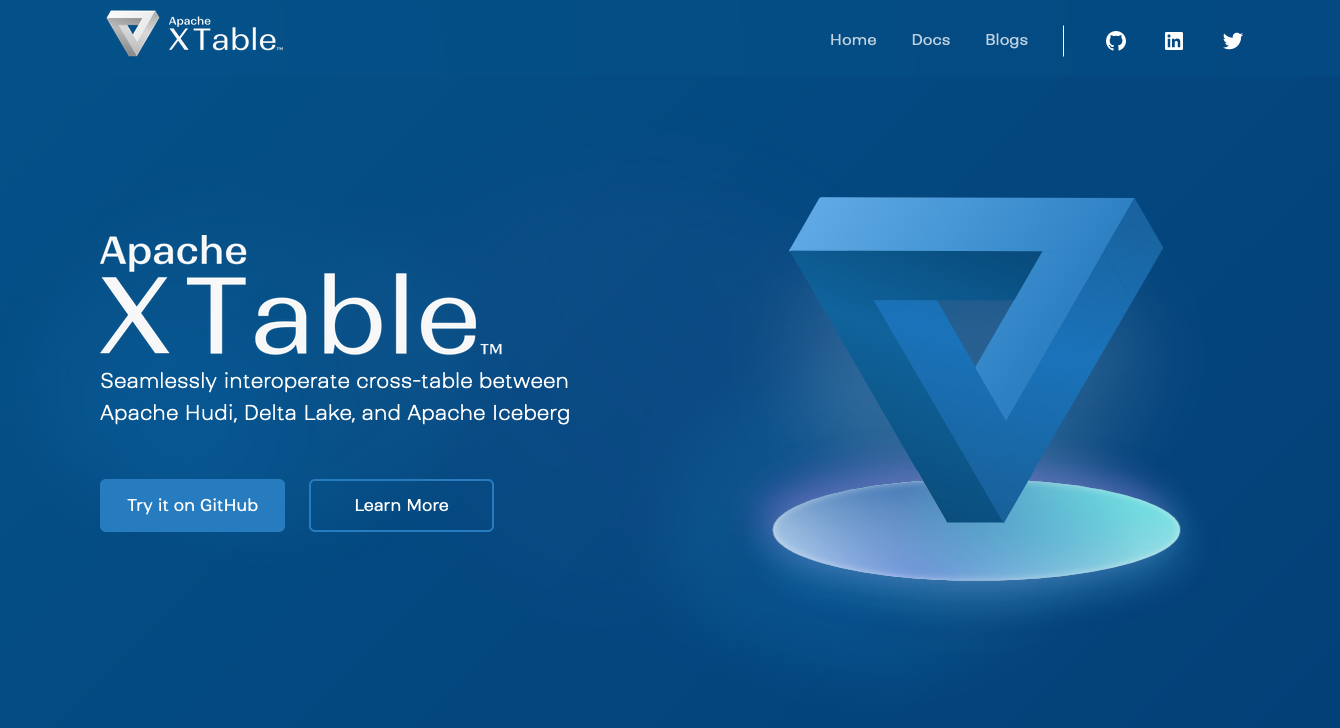

### Create config.yaml
```
-----------------config-0.yaml----------------------

sourceFormat: HUDI
targetFormats:
  - DELTA
  - ICEBERG
datasets:
  -
    tableBasePath: s3://datacouncil-kyle-demo/lakehouse/my_XTable/
    tableName: my_XTable

--------------------------------------------------
```

### Execute XTable .jar file
```java -jar utilities/target/utilities-0.1.0-SNAPSHOT-bundled.jar --datasetConfig config-0.yaml```

# ...Hudi -> Iceberg+Delta synchronization complete!

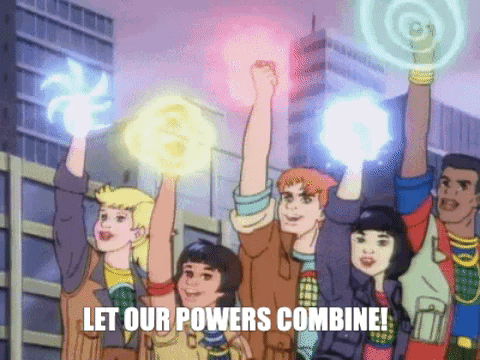

## (Check S3 metadata)

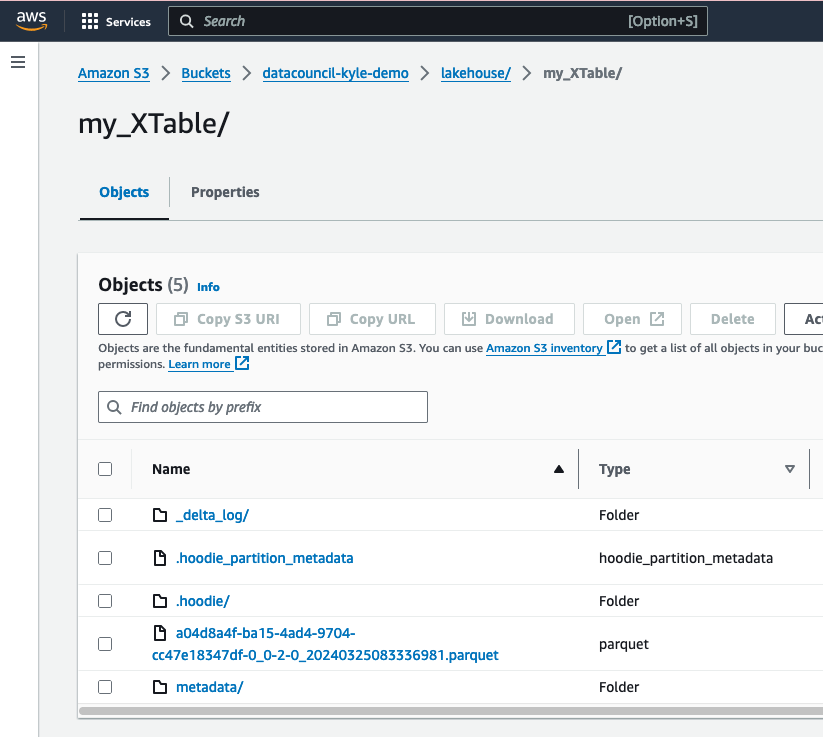

# Read table as Apache Iceberg

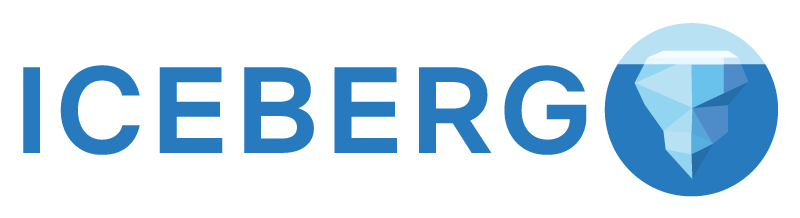

In [17]:
spark.read.format("iceberg").load("s3://path/to/my_XTable/").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------------------+--------------------+----------------------+--------------------+---+--------------------+---------+------+---------+---------+--------+-------------------+----------------+------------+----------------+
|_hoodie_commit_time|_hoodie_commit_seqno|  _hoodie_record_key|_hoodie_partition_path|   _hoodie_file_name| Op| replicadmstimestamp|invoiceid|itemid| category|    price|quantity|          orderdate|destinationstate|shippingtype|        referral|
+-------------------+--------------------+--------------------+----------------------+--------------------+---+--------------------+---------+------+---------+---------+--------+-------------------+----------------+------------+----------------+
|  20240325083336981|20240325083336981...|20240325083336981...|                      |a04d8a4f-ba15-4ad...|  I|2023-03-26 22:25:...|      190|    10|   Office|21.000000|       3|2016-04-28 00:00:00|              CA|       2-Day|           Other|
|  2024032508333

# Read table as Delta Lake

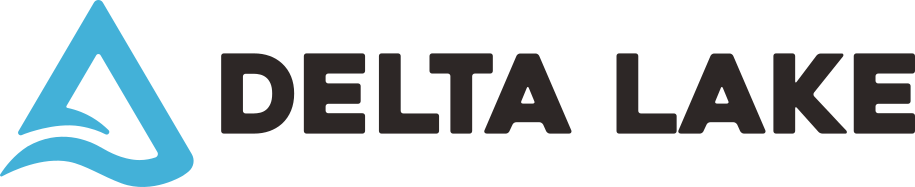

In [18]:
spark.read.format("delta").load("s3://path/to/my_XTable/").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------------------+--------------------+----------------------+--------------------+---+--------------------+---------+------+---------+---------+--------+-------------------+----------------+------------+----------------+
|_hoodie_commit_time|_hoodie_commit_seqno|  _hoodie_record_key|_hoodie_partition_path|   _hoodie_file_name| Op| replicadmstimestamp|invoiceid|itemid| category|    price|quantity|          orderdate|destinationstate|shippingtype|        referral|
+-------------------+--------------------+--------------------+----------------------+--------------------+---+--------------------+---------+------+---------+---------+--------+-------------------+----------------+------------+----------------+
|  20240325083336981|20240325083336981...|20240325083336981...|                      |a04d8a4f-ba15-4ad...|  I|2023-03-26 22:25:...|      190|    10|   Office|21.000000|       3|2016-04-28 00:00:00|              CA|       2-Day|           Other|
|  2024032508333

# Now Let's Try Something Else...
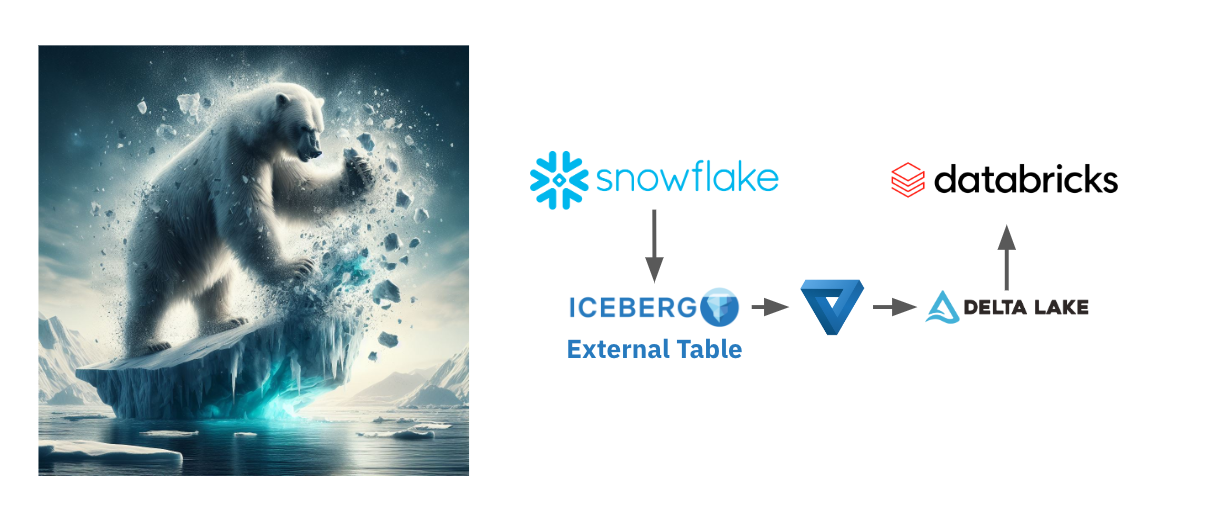

### Follow this tutorial to create Snowflake Iceberg EXT Tables:
https://quickstarts.snowflake.com/guide/getting_started_iceberg_tables/index.html

### External Volume in S3 here:
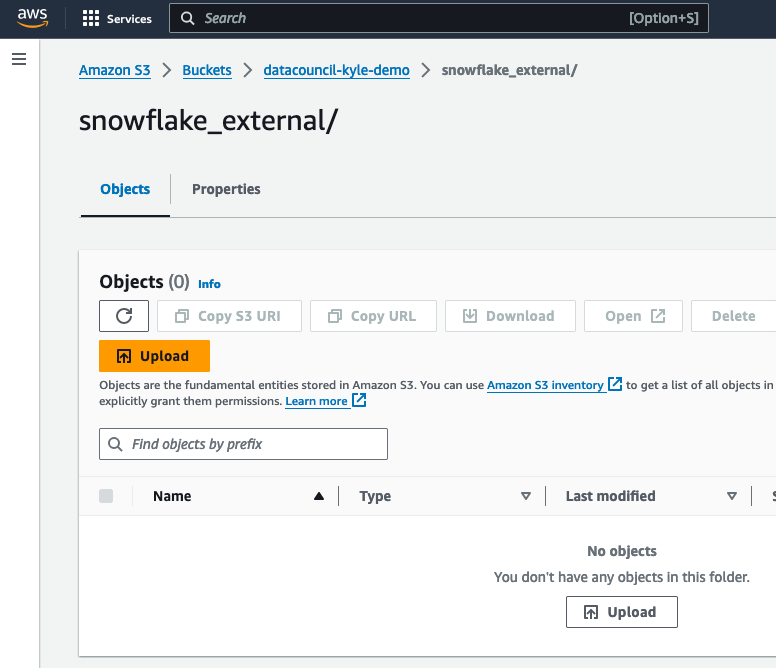

# Now let's query it as Iceberg:

In [22]:
spark.read.format("iceberg").load("s3://path/to/quickStart/").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+------------------+--------------------+-----------+---------------+---------+------------+--------------------+
|C_CUSTKEY|            C_NAME|           C_ADDRESS|C_NATIONKEY|        C_PHONE|C_ACCTBAL|C_MKTSEGMENT|           C_COMMENT|
+---------+------------------+--------------------+-----------+---------------+---------+------------+--------------------+
|        1|Customer#000000001|   IVhzIApeRb ot,c,E|         15|25-989-741-2988|      712|    BUILDING|to the even, regu...|
|        2|Customer#000000002|XSTf4,NCwDVaWNe6t...|         13|23-768-687-3665|      122|  AUTOMOBILE|l accounts. blith...|
|        3|Customer#000000003|        MG9kdTD2WBHm|          1|11-719-748-3364|     7498|  AUTOMOBILE| deposits eat sly...|
|        4|Customer#000000004|         XxVSJsLAGtn|          4|14-128-190-5944|     2867|   MACHINERY| requests. final,...|
|        5|Customer#000000005|KvpyuHCplrB84WgAi...|          3|13-750-942-6364|      794|   HOUSEHOLD|n accounts will h...|
|       

# Warning: Is Catalog the New Vendor Lock-In?

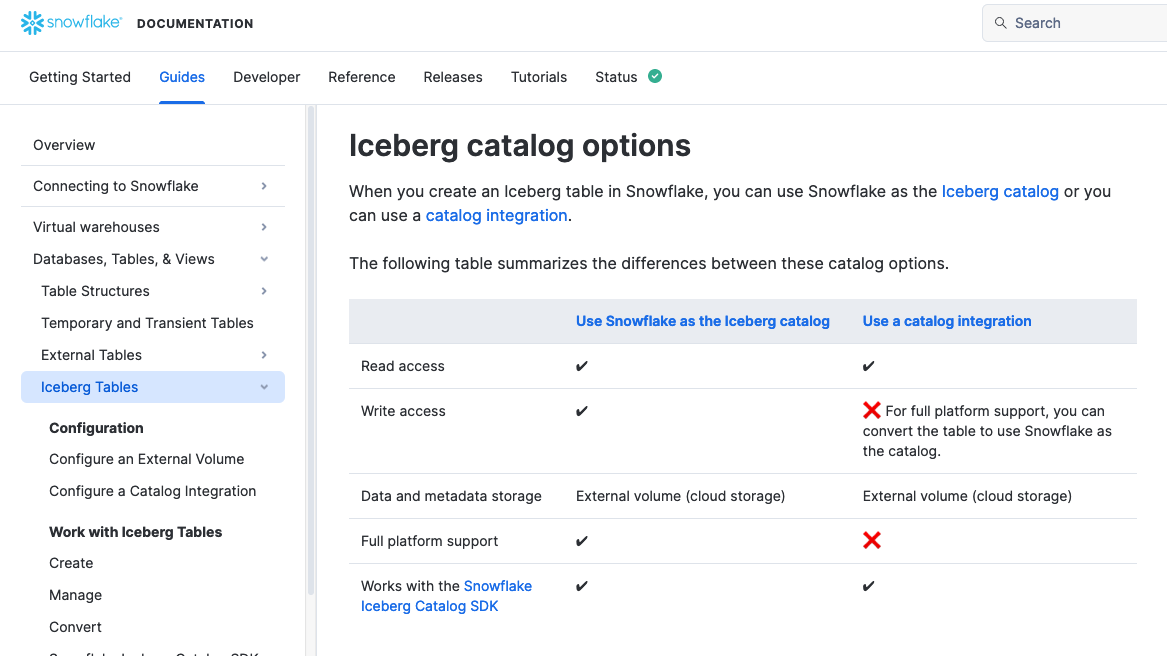


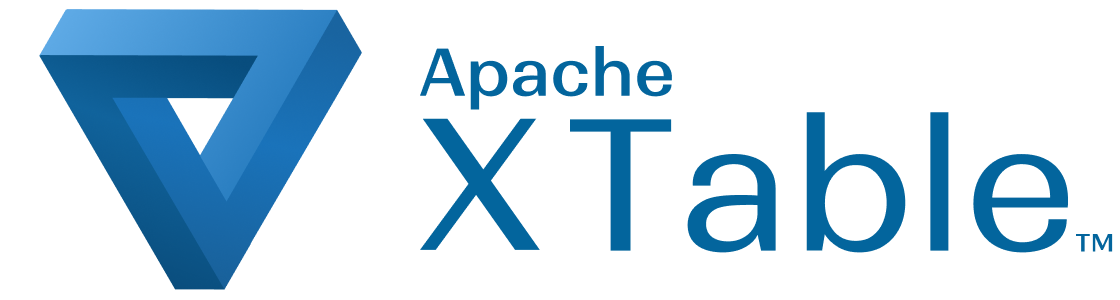

### Create config.yaml

```
-----------------config.yaml----------------------

sourceFormat: ICEBERG
targetFormats:
  - DELTA
datasets:
  -
    tableBasePath: s3://datacouncil-kyle-demo/snowflake_external/quickStart/
    tableName: quickStart

--------------------------------------------------
```

### Execute XTable .jar file
```java -jar utilities/target/utilities-0.1.0-SNAPSHOT-bundled.jar --datasetConfig config.yaml```

# ...Iceberg -> Delta synchronization complete!

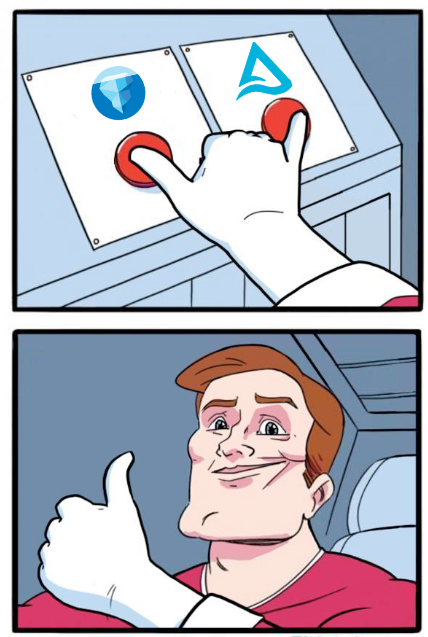

In [23]:
spark.read.format("delta").load("s3://path/to/quickStart/data/").show() 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+------------------+--------------------+-----------+---------------+---------+------------+--------------------+
|C_CUSTKEY|            C_NAME|           C_ADDRESS|C_NATIONKEY|        C_PHONE|C_ACCTBAL|C_MKTSEGMENT|           C_COMMENT|
+---------+------------------+--------------------+-----------+---------------+---------+------------+--------------------+
|    30001|Customer#000030001|Ui1b,3Q71CiLTJn4M...|          4|14-526-204-4500|     8848|   MACHINERY|frays wake blithe...|
|    30002|Customer#000030002|     UVBoMtILkQu1J3v|         11|21-340-653-9800|     5222|   MACHINERY|he slyly ironic p...|
|    30003|Customer#000030003|       CuGi9fwKn8JdR|         21|31-757-493-7525|     3015|    BUILDING|e furiously along...|
|    30004|Customer#000030004|     tkR93ReOnf9zYeO|         23|33-870-136-4375|     3309|  AUTOMOBILE|ssly bold deposit...|
|    30005|Customer#000030005|pvq4uDoD8pEwpAE01...|          9|19-144-468-5416|     -279|   MACHINERY|ructions behind t...|
|    300

# One more scenario:

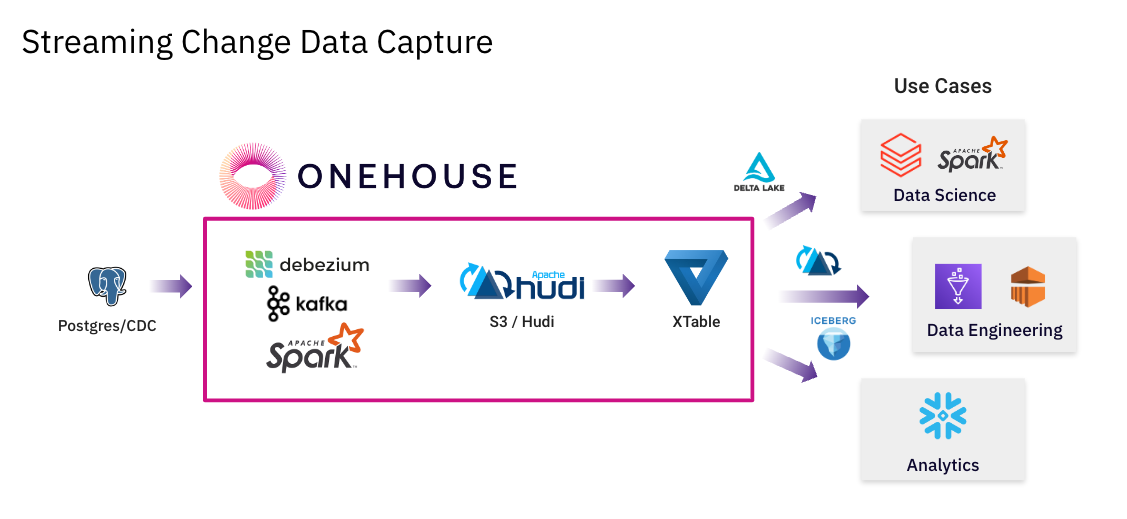

# DEMO END


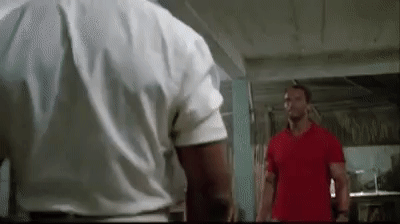